# Simulating a single cell

This notebook shows how to simulate a single cell using the `Cell` class.

## Compiling mechanisms

Before loading the cell, the cell mechanisms need to be compiled and provided. This compilation step is a performance requirement.

Refer to the [MOD2IR: High-Performance Code Generation for a Biophysically Detailed Neuronal Simulation DSL](https://dl.acm.org/doi/abs/10.1145/3578360.3580268) publication to learn more about the compilation process.


If the mechanisms are not compiled, you need to run the `nrnivmodl` command to perform the compilation.

The mechanisms are already available at the examples directory.

With NEURON installed, simply run the following command for the compilation.


**Note**: The compiled mechanisms need to be provided before importing bluecellulab.

In [ ]:
!nrnivmodl ../mechanisms

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap

import seaborn as sns

sns.set_style("whitegrid")

from bluecellulab import Cell, Simulation
from bluecellulab.circuit.circuit_access import EmodelProperties

from bluecellulab.stimulus.circuit_stimulus_definitions import OrnsteinUhlenbeck, ShotNoise
from bluecellulab import RNGSettings

--No graphics will be displayed.


## Loading the cell

A Cell is consisting of the two following components

- Electrophysiology - represented as hoc
- Morphology (shape) - represented as asc in this tutorial

In [3]:
hoc_file = Path("hoc") / "cADpyr_L2TPC.hoc"
morph_file = Path("morphology") / "rr110330_C3_idA.asc"

This command will compile the mechanisms files. The compilation step

In [4]:
morph_file

PosixPath('morphology/rr110330_C3_idA.asc')

In [5]:
emodel_properties = EmodelProperties(threshold_current=1.1433533430099487,
                                     holding_current=1.4146618843078613,
                                     AIS_scaler=1.4561502933502197)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

In [6]:
cell

Cell Object: <bluecellulab.cell.core.Cell object at 0x7fff308978d0>.
NEURON ID: cADpyr_L2TPC_bluecellulab_0x7fffbc0fbe10.

### Exploring cell's attributes

Morphology related attributes such as the Radius (Ra) of a section can be accessed as follows:

In [7]:
cell.soma.Ra

100.0

To see the children of a section, you can use the `children` attribute.

In [8]:
cell.soma.children()

[cADpyr_L2TPC_bluecellulab_0x7fffbc0fbe10[0].apic[0],
 cADpyr_L2TPC_bluecellulab_0x7fffbc0fbe10[0].dend[0],
 cADpyr_L2TPC_bluecellulab_0x7fffbc0fbe10[0].axon[0]]

Properties of other sections such as length(L) can also be displayed as follows:

In [9]:
cell.apical[0].Ra

100.0

In [10]:
cell.apical[0].L

9.530376893488256

Electrophysiological attributes such as the holding and threshold currents of the cell can be accessed as follows:

In [11]:
cell.hypamp  # holding current

1.4146618843078613

In [12]:
cell.threshold

1.1433533430099487

## Simulation

In this step we will apply some stimulation to the cell and run a simulation.

Here we create a Simulation object and add the cell we wish to simulate to it.

In [13]:
sim = Simulation()
sim.add_cell(cell)

### Adding a step current

Here a step current is set to be given to the cell during the simulation.

In [14]:
cell.add_step(start_time=15.0, stop_time=25.0, level=1.0)

TStim[0]

To run the cell, we call the `run` method of the simulation object.

In [15]:
sim.run(45, cvode=False)

Retrieving the time and voltage values of the simulation is done as follows:

In [16]:
time, voltage = cell.get_time(), cell.get_soma_voltage()

**Note**: To retrieve the voltage we used `cell.get_soma_voltage()`. In the next steps we will see how to retrieve the voltage from other sections.

Text(0, 0.5, 'Voltage (mV)')

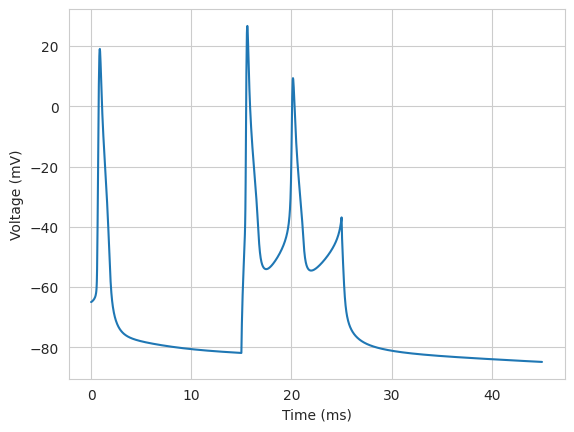

In [17]:
plt.plot(time, voltage)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

Here at the beginning we see a single spike and then we can clearly observe the impact of the step current we injected between 15 and 25 ms.

### Adding a more complex stimulation

Besides the step current, we can also add more complex stimulation to the cell.
In this example we will add a Poisson shot noise current to the cell.

Here we create a new Cell instance since the underlying NEURON implementation leaves some state after adding stimulus to the cell.

We do not want the previously injected step current to interfere with the new stimulus.

In [18]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
sim = Simulation()
sim.add_cell(cell)

Here to define the ShotNoise stimulus, we need to create an object of type ShotNoise. The attributes of the stimulus object (ShotNoise object) are checked via a dynamic type checker to early detect errors and misuses.

In [19]:
shotnoise_stimulus = ShotNoise(
    target="single-cell", delay=15, duration=20,
    rise_time=0.4, decay_time=4, rate=2E3, amp_mean=40E-3, amp_var=16E-4,
    seed=3899663
)

Since ShotNoise is a stochastic signal, we need to set the rng_settings attribute of the cell.

In [20]:
rng_obj = RNGSettings.get_instance().set_seeds(base_seed=42)

Here we add the shotnoise to the middle point (denoted by 0.5) of soma 

In [21]:
time_vec, stim_vec = cell.add_replay_shotnoise(
    cell.soma, 0.5,
    shotnoise_stimulus,
    shotnoise_stim_count=3)
time_vec = time_vec.to_python()
stim_vec = stim_vec.to_python()

Here is the current we injected to the cell.

Text(0, 0.5, 'Current (nA)')

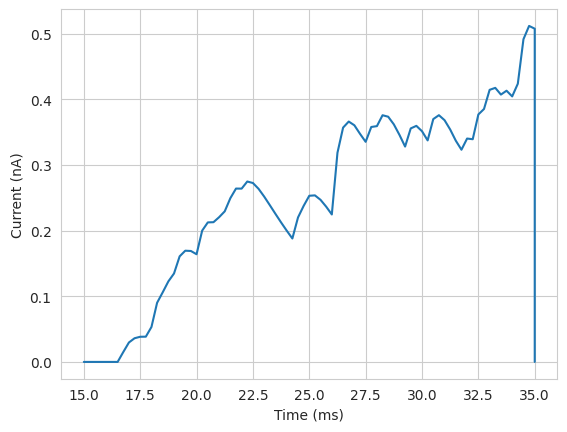

In [22]:
plt.plot(time_vec, stim_vec)
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")

In [23]:
sim.cells

[Cell Object: <bluecellulab.cell.core.Cell object at 0x7fff48f60f50>.
 NEURON ID: cADpyr_L2TPC_bluecellulab_0x7fff1983b290.]

In [24]:
sim.cells[0] is cell

True

In [25]:
sim.run(45, cvode=False)
time, voltage = cell.get_time(), cell.get_soma_voltage()

The figure below shows how the cell responded to the shotnoise. 

As in the previous stimulus, there is a single spike at the beginning and the impact of shotnoise begins at 15 ms and lasts for 20ms.

Compared to the previous voltage figure, here we can tell that the shotnoise has a different effect on the cell.

Text(0, 0.5, 'Voltage (mV)')

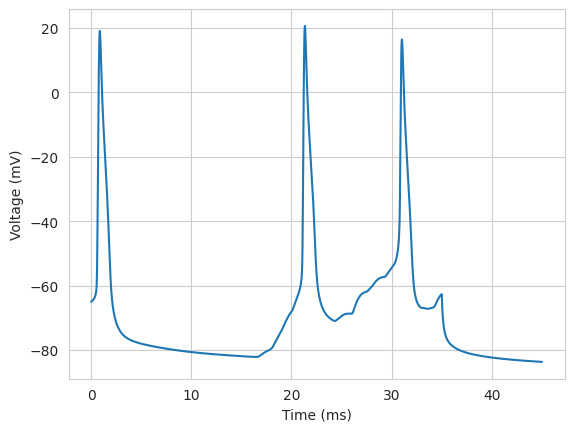

In [26]:
plt.plot(time, voltage)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

### Using the spike detector

The spike detector can be used to detect the exact time of the spikes.

In [27]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
tstim = cell.add_ramp(start_time=10.0, stop_time=30.0, start_level=0.5, stop_level=4.0)
sim = Simulation()
sim.add_cell(cell)

Before running the simulation, we need to add the spike detector via `start_recording_spikes` to the cell and set the threshold voltage.

Above the threshold is considered a spike. 

`get_recorded_spikes` returns the time of the spikes from the section "soma".

In [28]:
cell.start_recording_spikes(None, location="soma", threshold=-10)
sim.run(45, cvode=False)
spikes = cell.get_recorded_spikes(location="soma", threshold=-10)
time, voltage = cell.get_time(), cell.get_soma_voltage()

In [29]:
print(f"spike times: {spikes}")

spike times: [0.7250000000999994, 10.925000000099914, 14.775000000099695, 18.150000000099503, 21.87500000009929, 27.72500000009896]


The detected spikes are denoted as red dashed lines in the voltage plot.

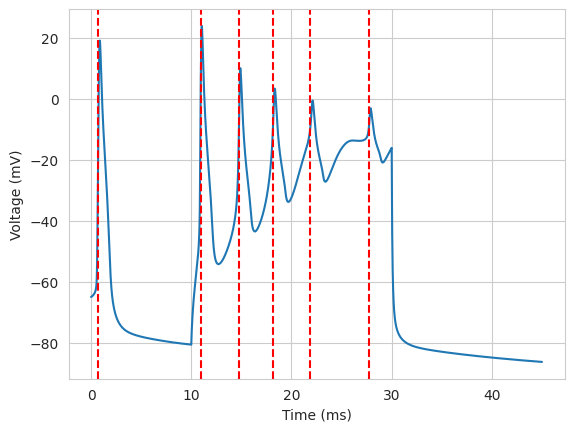

In [30]:
plt.plot(time, voltage)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
# add spikes to the plot as dashed lines
for spike in spikes:
    plt.axvline(spike, c="r", linestyle="--")

### Recording from another section

Besides soma, the voltage can be recorded from other sections as well.
Here we record from the axon initial segment (ais) and plot the voltage from both soma and AIS.

In [31]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
cell.add_ramp(start_time=10.0, stop_time=30.0, start_level=0.5, stop_level=4.0)
sim = Simulation()
sim.add_cell(cell)
cell.add_ais_recording(dt=cell.record_dt)

In [32]:
sim.run(45, cvode=False)

In [33]:
time = cell.get_time()
soma_voltage = cell.get_soma_voltage()
ais_voltage = cell.get_ais_voltage()

The dotted line shows the recordings from the axon initial segment.

Text(0, 0.5, 'Voltage (mV)')

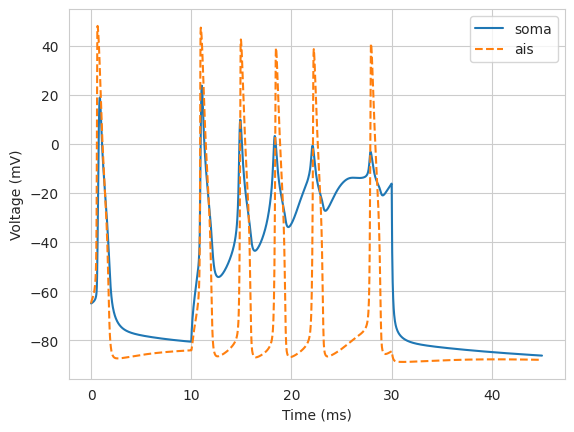

In [34]:
plt.plot(time, soma_voltage, label="soma")
plt.plot(time, ais_voltage, label="ais", linestyle="--")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

### Recording from all sections

In this step we will go one level beyond and record from every section of the neuron.

This time we will add an Ornstein-Uhlenbeck process current to the cell.

In [35]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
stimulus = OrnsteinUhlenbeck(
            target="single-cell", delay=15, duration=20,
            tau=2.8, sigma=0.64, mean=0.729, mode="current_clamp", dt=0.25, seed=1
        )
rng_obj = RNGSettings.get_instance().set_seeds(base_seed=42)
sim = Simulation()
sim.add_cell(cell)

With `add_allsections_voltagerecordings` we enable recording from every section of the cell.

In [36]:
cell.add_allsections_voltagerecordings()

In [37]:
time_vec, stim_vec = cell.add_ornstein_uhlenbeck(cell.soma, 0.5, stimulus, stim_count=1)


The Ornstein-Uhlenbeck signal is plotted below.

Text(0, 0.5, 'Current (nA)')

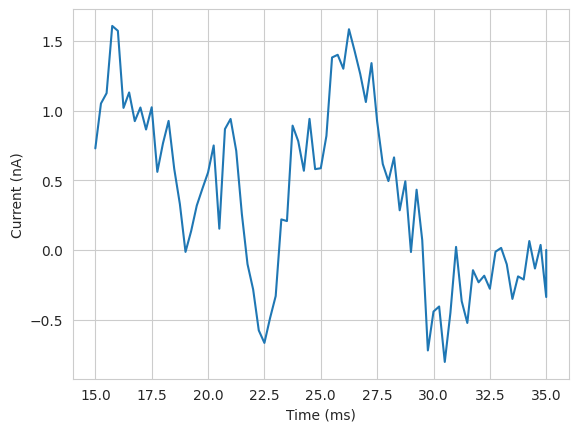

In [38]:
plt.plot(time_vec, stim_vec)
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")

In [39]:
sim.run(45, cvode=False)

To get the recorded voltage from all sections, we use `get_allsections_voltage`.

In [40]:
recordings = cell.get_allsections_voltagerecordings()
time = cell.get_time()

Here in order to display how the voltage changes in different sections, we plot the voltage of the soma and its subsections. We will record voltages at the center (or (0.5) location) of each section.

We use the `subtree` method to get the subsections.

In [41]:
recordings

{'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].soma[0]': array([-65.        , -60.97827517, -57.80286608, ..., -86.73682021,
        -86.73984968, -86.74287885]),
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[0]': array([-65.        , -62.40622012, -59.8769138 , ..., -86.70528874,
        -86.70836571, -86.71144211]),
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[1]': array([-65.        , -64.7966702 , -64.39596325, ..., -86.63942062,
        -86.6425901 , -86.64575869]),
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[2]': array([-65.        , -64.99940043, -64.96681525, ..., -86.60717363,
        -86.61037683, -86.61357915]),
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[3]': array([-65.        , -65.00074187, -64.97178022, ..., -86.60544006,
        -86.6086445 , -86.61184807]),
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[4]': array([-65.        , -64.86630225, -64.54886861, ..., -86.63391453,
        -86.63709017, -86.64026491]),
 'cADpyr_L2TPC_bluecellulab_

In [42]:
subtree = [x.name() for x in cell.soma.subtree()][:10]

We will now plot the voltages recorded for different locations in the subtree. We want to show the distances from the soma of the recording locations along with the section name.
We will also plot voltage recordings from the soma and the axon initial segment.

To calculate the distance of each section from the soma, we use the `distance` method from NEURON. The `select_dendritic_recordings` and `distances_to_soma` methods will be used to select the dendritic recordings and calculate the distances to the soma.

In [43]:
import neuron
from itertools import islice

def select_dendritic_recordings(all_recordings):
        """Select dendritic recordings from all recordings."""
        res = {}
        for key, value in all_recordings.items():
            if "myelin" in key:
                continue
            else:
                res[key] = value
        return res

def distances_to_soma():
    """Return the distance to the soma for each section."""
    res = {}
    all_recordings = cell.get_allsections_voltagerecordings()
    dendritic_recordings = select_dendritic_recordings(all_recordings)
    soma = cell.soma
    for key in dendritic_recordings.keys():
        section_name = key.rsplit(".")[-1].split("[")[0]  # e.g. "dend"
        section_idx = int(key.rsplit(".")[-1].split("[")[1].split("]")[0])  # e.g. 0
        attribute_value = getattr(cell.cell.getCell(), section_name)
        section = next(islice(attribute_value, section_idx, None))
        # section e.g. cADpyr_L2TPC_bluecellulab_x[0].dend[0]
        res[key] = neuron.h.distance(soma(0.5),section(0.5))
    return res

We now calculate the distances of the sections to the soma and plot the voltages recorded from the soma and the axon initial segment.

In [44]:
distances = distances_to_soma()
distances = {k: float(v) for k, v in distances.items()} # convert to float
distances = dict(sorted(distances.items(), key=lambda x: x[1])) # sort by distance

You can see the sorted distances of the sections to the soma below.

In [45]:
distances

{'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].soma[0]': 0.0,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[0]': 4.132154495613162,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].apic[0]': 4.765188446744128,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].apic[1]': 14.31071445662771,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].apic[56]': 18.379717313542777,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[7]': 18.72565188608846,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].axon[0]': 19.58382446681999,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].apic[2]': 21.36621485709223,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[1]': 22.94928443789968,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[4]': 28.591305994698544,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].apic[58]': 32.48306590224313,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].dend[9]': 35.667618263231226,
 'cADpyr_L2TPC_bluecellulab_0x7fff197a0150[0].apic[3]': 35.669389444568615,
 'cADpyr_L2TPC_bluecellulab_0x7ff

In the plot above, the colour intensity is given by the order of subtree.

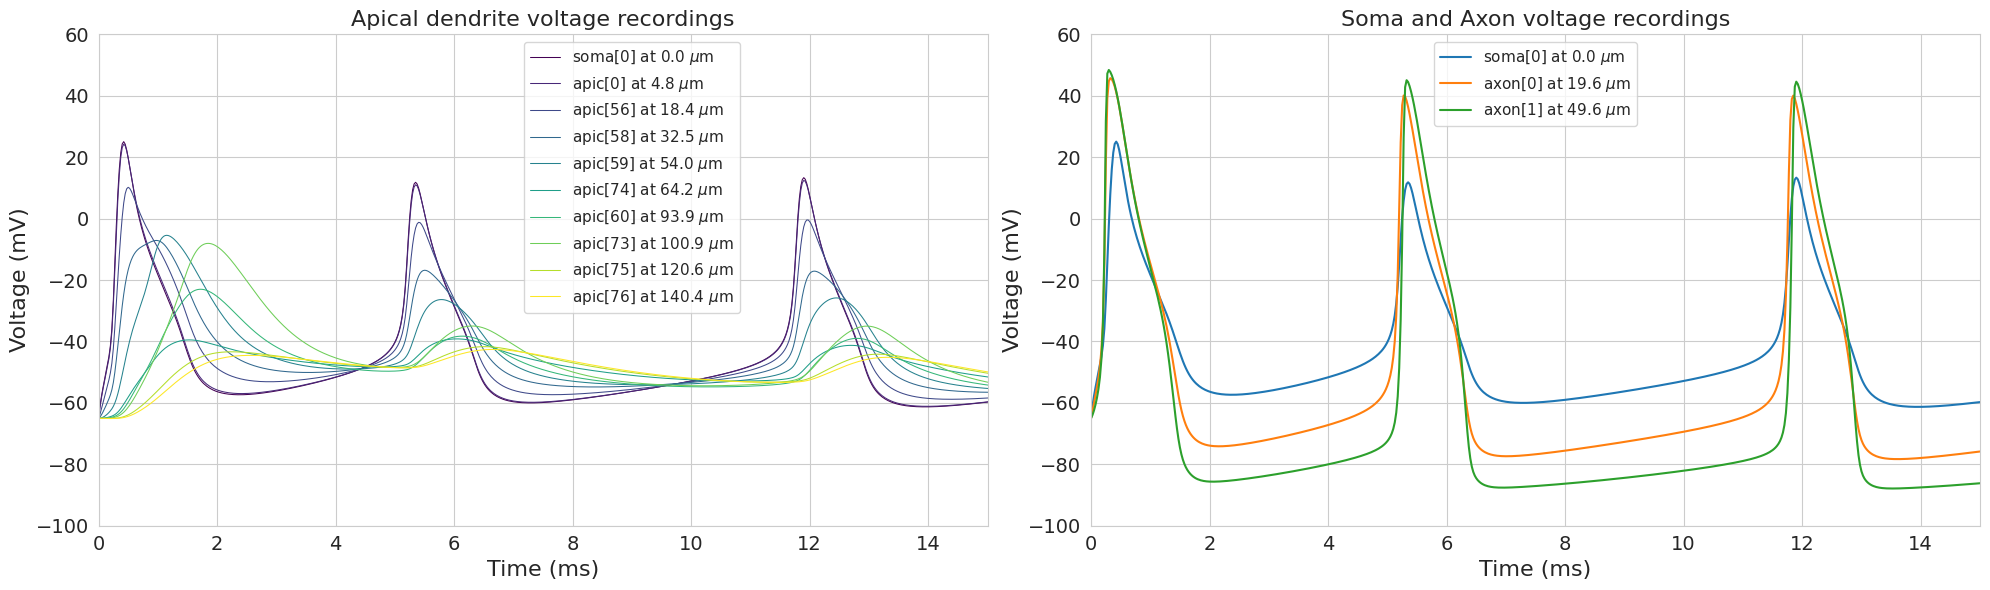

In [46]:
# Define colormap
color_map = get_cmap('viridis', len(subtree))
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

title_fontsize = 16
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 11

recordings_subtree = {key: recordings[key] for key in subtree}
i=0

# Plot the voltage recordings from the subtree
for key in distances:
        if key in subtree:
                voltage = recordings[key]
                ax[0].plot(time, voltage, label=f'{key.split(".")[-1]} at {round(distances[key], 1)} $\mu$m', linewidth=0.75, color=color_map(i))
                i+=1

ax[0].legend(loc="upper center", bbox_to_anchor=(0.6, 1.0),fontsize=legend_fontsize)
ax[0].set_title("Apical dendrite voltage recordings", fontsize=title_fontsize)
ax[0].set_xlim(0, 15)
ax[0].set_ylim(-100, 60)
ax[0].set_xlabel("Time (ms)", fontsize=label_fontsize)
ax[0].set_ylabel("Voltage (mV)", fontsize=label_fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)


# Plot soma and axon voltage recordings
color_map = get_cmap('tab10', len(subtree))
i=0
for key in distances.keys():
    if "axon" in key or "soma" in key:
        label = f'{key.split(".")[-1]} at {round(distances[key], 1)} $\mu$m'
        ax[1].plot(time, recordings[key], label=label, color=color_map(i))
        i+=1

ax[1].legend(fontsize=legend_fontsize)
ax[1].set_title("Soma and Axon voltage recordings",fontsize=title_fontsize)
ax[1].set_xlim(0, 15)
ax[1].set_ylim(-100, 60)
ax[1].set_xlabel("Time (ms)",fontsize=label_fontsize)
ax[1].set_ylabel("Voltage (mV)",fontsize=label_fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

Figure description:

Left: The voltages in the soma and different sections along the apical dendrite. With increasing distance from the soma, the membrane potential decreases in amplitude.

Right: The voltages in the soma and the AIS sections: axon[0] and axon[1]. The spike initiation (see between 0-2 ms) occurs in axon[0] section slightly before than that in the soma.